In [ ]:
!pip install bertopic
!pip install -U numpy
!pip install -U plotly

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
from bertopic import BERTopic
import pandas as pd
from collections import defaultdict
import random
from itertools import chain
import pickle
from tqdm import tqdm
from collections import Counter
from operator import itemgetter
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.graph_objs import *

In [3]:
# CONSTANTS

random.seed(42)

# Quotebank years list
YEARS = range(2015, 2021)

# Path to filtered quotebank dataset (one party per speaker)
QUOTEBANK_ONE_PARTY = {year: f"/content/drive/MyDrive/Quotebank_sets/ADA_data/quotebank_one_party-{year}.csv" for year in YEARS}

# Maximum number of quotes per party in each of the 6 years
MAX_QUOTES_PER_PARTY = [170, 225, 155, 145, 145, 530]

# Path to fitted models by year
FITTED_BERT_PER_YEAR_PATH = {year: f'/content/drive/MyDrive/Quotebank_sets/ADA_models/{year}_topic_model' for year in YEARS}

# Path to quotes per year used for fitting
FITTED_QUOTES_PER_YEAR_PATH = {year: f'/content/drive/MyDrive/Quotebank_sets/ADA_data/{year}_fit_data.pkl' for year in YEARS}

# Path to topics for quotes, per year
QUOTES_TOPICS_PER_YEAR_PATH = {year: f'/content/drive/MyDrive/Quotebank_sets/ADA_models/{year}_all_topics.pkl' for year in YEARS}

# Path to final quotes with named topics dataframe
FINAL_NAMED_TOPICS_QUOTES_PER_YEAR_PATH = {year: f'/content/drive/MyDrive/Quotebank_sets/ADA_data/final-quotes-named-topics-{year}.csv' for year in YEARS}



##4.5. Yearly topics interests and parties relations

### 4.5.1. Helper functions

In [199]:
def choose_quotes(row, max_quotes):
    """
    If number of quotes per party below max_quotes, select all,
    otherwise select randomly max_quotes quotes for a party.
    """
    if not row['select_all']:
        # Randomly sample max_quotes quotes
        row['quotes_list'] = random.sample(row['quotes_list'], max_quotes)
        row['number'] = max_quotes
    return row


def get_quotes_for_year_fit():
    """
    Get yearly political parties quotes required for fitting BERTopic.
    """
    # Dictionary with quotes per year (around 100K quotes for each year)
    quotes_by_year = defaultdict(list)

    for i, quote_year in tqdm(enumerate(YEARS)):
        df = pd.read_csv(QUOTEBANK_ONE_PARTY[quote_year], index_col=[0])
        # Group by party
        groupby_party = df.groupby('party_one')['quotation'].agg(quotes_list=list, number=len)
        # Create boolean column with True values if number of quotes for party is above threshold
        groupby_party['select_all'] = groupby_party['number'] <= MAX_QUOTES_PER_PARTY[i]
        # Create a the list of quotes for a year
        quotes = groupby_party.apply(lambda x: choose_quotes(x, MAX_QUOTES_PER_PARTY[i]), axis=1)['quotes_list'].values
        quotes = list(chain.from_iterable(quotes))
        quotes_by_year[quote_year] = quotes
        # Also save data used for fiiting because we need it later
        with open(FITTED_QUOTES_PER_YEAR_PATH[quote_year], 'wb') as f:
            pickle.dump(quotes, f)

    return quotes_by_year


def fit_years(start_year, end_year):
    """
    Function for fiting BERTopic on quotes from each year.
    """
    yearly_quotes = get_quotes_for_year_fit()
    for i, quote_year in enumerate(range(start_year, end_year)):
        # Instantiate BERTopic
        topic_model = BERTopic(verbose=True)
        # Fit a model on topics of each year
        topics = topic_model.fit(yearly_quotes[quote_year])
        print(f'Saving model for {quote_year}')
        # Save model
        topic_model.save(FITTED_BERT_PER_YEAR_PATH[quote_year])


def transform_years(models_by_year, quotes_by_year):
    """
    Function for predicting topics on quotes from each year.
    """
    for year in models_by_year.keys():
        # Transform all data from a year
        model_topics_all, model_probs_all = models_by_year[year].transform(quotes_by_year[year])
        # Save predicted topics
        with open(QUOTES_TOPICS_PER_YEAR_PATH[year], 'wb') as f:
            pickle.dump([model_topics_all, model_probs_all], f)


def get_all_quotes_for_year(year, return_quote_ids=False):
    """
    Get all quotes from a year.
    """
    # Read quotebank data for one year
    df = pd.read_csv(QUOTEBANK_ONE_PARTY[year])
    # If more than 1.6M quotes, pick randomly 1.6M (due to memory issues)
    if len(df) > 1600000:
        print("Reduced to 1.6 M quotes")
        df = df.sample(1600000, axis=0)
    res = df[['quoteID', 'quotation']]
    if return_quote_ids:
        return res['quotation'].tolist(), res['quoteID'].tolist()
    else:
        return res['quotation'].tolist(), None


def per_years_analysis(fit_first=False, transform_first=False, start_year=2015,
                       end_year=2021, reduced_topic_nr=80):
    """
    Full pipeline for obtaining quotes topics for specific years.
    NOTE: Maybe just one year can be run at a time due to memory issues. 
    """
    # Fit models first, if necessary
    if fit_first:
        fit_years(start_year, end_year)

    # Instantiate a BERTopic model for each year
    models = {}
    quotes_all = {}
    for year in range(start_year, end_year):
        # Store models for each year
        models[year] = BERTopic(verbose=True).load(FITTED_BERT_PER_YEAR_PATH[year])
        # Get all quotes for each year
        year_quotes, year_quote_id = get_all_quotes_for_year(year, return_quote_ids=False)
        quotes_all[year] = year_quotes

    # Predict topics on each year quotes, if necessary
    if transform_first:
        transform_years(models, quotes_all)

    for year in range(start_year, end_year):
        # Get quotes topics
        with open(QUOTES_TOPICS_PER_YEAR_PATH[year], 'rb') as topic_file:
            model_topics_all, model_probs_all = pickle.load(topic_file)
        
        # Number of quotes after removing non-clustered ones
        only_clustered = [x for i, x in enumerate(quotes_all[year]) if model_topics_all[i] != -1]
        only_clustered_id = [year_quote_id[i] for i, x in enumerate(quotes_all[year]) if model_topics_all[i] != -1]
        # model_probs_all = [x for i, x in enumerate(model_probs_all) if model_topics_all[i] != -1]
        model_topics_all = [x for x in model_topics_all if x != -1]

        # Reduce the number of topics to a predefined number
        new_topics, new_probs = models[year].reduce_topics(only_clustered, model_topics_all, nr_topics=reduced_topic_nr)
        # Create a dataframe with the quotes and their topic as integers
        quote_to_topic_df = pd.DataFrame({'quote_id': only_clustered_id, 'quote': only_clustered, 'topic': new_topics}). set_index('quote_id')

        # Map integer topics to topic names
        topic_mapping = topic_strings_list_to_dict(MANUAL_LABELS[year])

        # Merge this dataframe with the quotebank dataset
        df_original = pd.read_csv(QUOTEBANK_ONE_PARTY[year], index_col=[0]).set_index('quoteID')
        final_df = df_original.merge(quote_to_topic_df[['topic']], how='inner', left_index=True, right_index=True)
        final_df = final_df.merge(topic_mapping, how='inner', left_on='topic', right_index=True)

        # Save the final dataframe to .csv format
        final_df.to_csv(FINAL_NAMED_TOPICS_QUOTES_PER_YEAR_PATH[year])

def topic_strings_list_to_dict(year_topics):
    """
    Returns dataframe with mapping between topic integers and manually labeled topic names.
    """
    d = {}
    # Transform a list of strings modeled as topic_int - topic_name to a dictionary.
    for s in year_topics:
        k, v = s.split(' - ')
        d[int(k)] = v
    # Create a dataframe with the mapping between topic numbers and topic names
    topic_mapping = pd.DataFrame({'topic_number': d.keys(), 'topic_name':d.values()}).set_index('topic_number')

    return topic_mapping

###4.5.2. Get quotes' topics


In [198]:
MANUAL_LABELS = {2019: [
'0 - indian politics',
'1 - healthcare',
'2 - women',
'3 - education',
'4 - transportation',
'5 - southern asia',
'6 - brexit',
'7 - voting/elections',
'8 - australia/oceania',
'9 - abortion',
'10 - war and violence (peace)',
'11 - tourism',
'12 - senate',
'13 - veterans/patriotism/celebration',
'14 - south-america',
'15 - law enforcement',
'16 - illegal substances',
'17 - turkey/syria',
'18 - communication/leadership',
'19 - lgbt/gender equality',
'20 - uk',
'21 - corruption/crimes',
'22 - canada',
'23 - israel/palestine',
'24 - european union',
'25 - filipines',
'26 - policies',
'27 - russia',
'28 - pakistan/afghanistan',
'29 - parties',
'30 - immigration/refugees',
'31 - ministers',
'32 - border/wall',
'33 - meetings/public relations',
'34 - terrorism',
'35 - unions',
'36 - national organizations/international cooperation',
'37 - sea-life/fishing',
'38 - flooding',
'39 - agriculture',
'40 - governmnet/president',
'41 - apologize/regret',
'42 - guns',
'43 - challenges/lies',
'44 - tax',
'45 - economy',
'46 - climate change',
'47 - smoking',
'48 - india',
'49 - econimic situation/banks',
'50 - investigations',
'51 - rights/freedom',
'52 - parliament',
'53 - military/middle-east',
'54 - community support/suicides',
'55 - africa',
'56 - security',
'57 - communication/speech',
'58 - racism',
'59 - social networks/devices',
'60 - resignation/strikes',
'61 - nigeria',
'62 - safety',
'63 - councils',
'64 - imports/exports',
'65 - regulations',
'66 - budget/spendings',
'67 - justice',
'68 - media',
'69 - jews',
'70 - negotiations',
'71 - housing/homelessness',
'72 - natural resources/recycling',
'73 - renewable energy',
'74 - malaysia/singapore',
'75 - race/racing/color',
'76 - aviation',
'77 - sports',
'78 - urban areas/mayors',
'79 - crisis/disasters',
'80 - science/progress'
],
2015: [
'0 - education',
'1 - transportation',
'2 - women',
'3 - communication/public relations',
'4 - crimes',
'5 - southern asia',
'6 - community/leadership',
'7 - iran/russia',
'8 - sports',
'9 - refugees/immigrants',
'10 - india',
'11 - media',
'12 - european union',
'13 - diseases/vaccines',
'14 - gender equality',
'15 - ministers',
'16 - war and violence (peace)',
'17 - negotiations',
'18 - healthcare',
'19 - voting/elections',
'20 - canada',
'21 - planning/proposals',
'22 - democracy',
'23 - economy',
'24 - israel/palestine',
'25 - africa',
'26 - filipines',
'27 - malaysia/singapore',
'28 - illegal substances',
'29 - employment/wages',
'30 - kids/family',
'31 - uk',
'32 - middle-east',
'33 - energy',
'34 - justice',
'35 - tax',
'36 - national organizations/international cooperation',
'37 - parliament',
'38 - politics',
'39 - terrorism',
'40 - australia/oceania',
'41 - government',
'42 - legislation',
'43 - rights/freedom',
'44 - loan/debts',
'45 - food/hunger',
'46 - religion',
'47 - policies/regulations',
'48 - east-asia',
'49 - sea-life/fishing',
'50 - south-america',
'51 - agriculture',
'52 - urban areas/mayors',
'53 - business and innovation',
'54 - pollution',
'55 - syria/isis',
'56 - flooding',
'57 - abortion',
'58 - councils/meetings',
'59 - islam',
'60 - law enforcement',
'61 - france/terrorism',
'62 - climate change',
'63 - apologize/regret',
'64 - senate',
'65 - island countries',
'66 - lgbt',
'67 - problems/solutions',
'68 - veterans/patriotism',
'69 - parties',
'70 - markets',
'71 - economic sitaution',
'72 - budget/spendings',
'73 - natural disasters',
'74 - housing/homelessness',
'75 - renewable energy',
'76 - guns/shootings',
'77 - aviation',
'78 - protests',
'79 - science/progress',
'80 - unions'
]}

Using the *per_year_analysis()* function we obtain a specific topic name for each quote. The process, for each year, is summarized below:


*   Train BERTopic on ~100K quotes. We choose the ~100K quotes in a stratified manner. Check function *get_quotes_for_year_fit()*.
*   Choose maximum 1.6 M quotes at random and predict their topics (as integers). Even though in some years there are more than 1.6M quotes, we are limited by the RAM Colab memory.
*   Remove the unclustered quotes.
*   Reduce the number of initially outputed topics (~800) to only 80 topics. Some of the reduced topics may still represent multiple slightly different topics due to the massive reduction.
*   Based on the 10 most representative words (resulted from BERTopic) for each reduced topic, we manually labeled them. We used the *get_topic(self, topic)* function from BERTopic to get the top words from a specific topic and also looked for different quotes from a specific topic to get a better undestanding of the main subject. We create a list of labels for each year.
*   Merge the quotebank dataset with the topic labels in order to obtain a topic for each quote.

We conduct our analysis for the years **2015** and **2019**, but this could be easily extend to all other years

In [ ]:
per_years_analysis(fit_first=True, transform_first=True, start_year=2015,
                   end_year=2016, reduced_topic_nr=80)
per_years_analysis(fit_first=False, transform_first=False, start_year=2019,
                   end_year=2020, reduced_topic_nr=80)

After the entire filtering the 2 dataframes will contain:

*   2015 - 669642 clustered quotes and 1641 parties
*   2019 - 693962 clustered quotes and 1671 parties


###4.5.3.Yearly topic interests
In the notebook we are presenting the analysis only for 2019, but the website will contain data from 2015 too.

In [204]:
# Set the desired year for analysis
year = 2019

In [206]:
# Read the dataframe used for analysis
final_df = pd.read_csv(FINAL_NAMED_TOPICS_QUOTES_PER_YEAR_PATH[year], index_col=[0])
# Remove independent politicians
final_df = final_df[final_df['party_one'] != 'independent politician']
final_df.head()

,quotation,qids,party,party_qcodes,party_one,speaker,topic,topic_name
2019-06-28-043094,It is my view that the answer to their problem...,['Q324546'],['Republican Party'],['Q29468'],Republican Party,Marco Rubio,16,illegal substances
2019-04-04-097232,The flow of illicit fentanyl largely from Chin...,['Q324546'],['Republican Party'],['Q29468'],Republican Party,Marco Rubio,16,illegal substances
2019-10-18-068133,Our situation in these prisons is very difficu...,['Q324546'],['Republican Party'],['Q29468'],Republican Party,Marco Rubio,16,illegal substances
2019-09-11-017333,Do you believe the United States has committed...,['Q324546'],['Republican Party'],['Q29468'],Republican Party,Marco Rubio,16,illegal substances
2019-04-09-061930,legalized trafficking of persons.,['Q324546'],['Republican Party'],['Q29468'],Republican Party,Marco Rubio,16,illegal substances


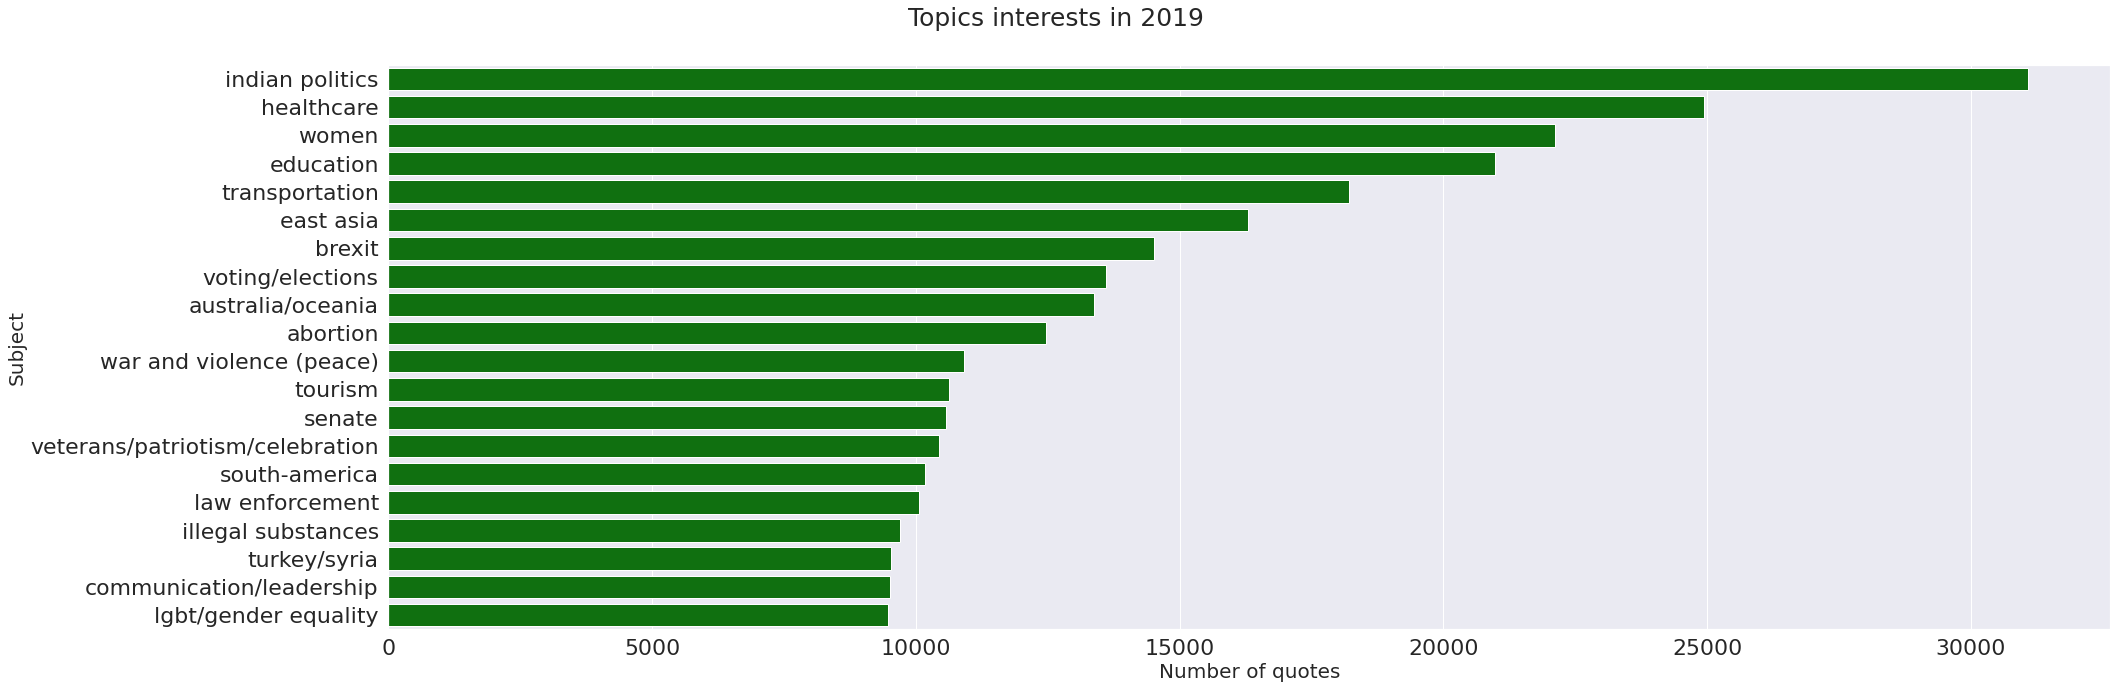

In [219]:
topic_count_per_year = Counter(final_df['topic_name'])
most_common_topics = dict(topic_count_per_year.most_common())
most_common_topics = pd.DataFrame({'subject': most_common_topics.keys(), 'nr_quotes': most_common_topics.values()})
most_common_topics[:20]

fig, ax = plt.subplots(1, 1, figsize=(30, 10))
sns.set(font_scale=2)
sns.barplot(x=most_common_topics['nr_quotes'][:20], y=most_common_topics["subject"][:20], 
                         data=most_common_topics,ax=ax, color='green')

fig.tight_layout()
plt.xlabel("Number of quotes", fontsize=20)
plt.ylabel("Subject", fontsize=20)
fig.suptitle("Topics interests in {}".format(year), fontsize=25)
fig.subplots_adjust(top=0.90)

In [209]:
party_to_topics = final_df.groupby(['party_one', 'topic_name']).count()['quotation']

In [210]:
most_important_k = 20
less_important_parties = list(dict(Counter(final_df['party_one']).most_common()[most_important_k:]).keys())
party_to_topics_df = pd.DataFrame(party_to_topics).rename(columns={'quotation': 'nr_quotes'})
party_to_topics_df = party_to_topics_df.drop(less_important_parties, level=0)
party_to_topics_df

nr_quotes
party_one                 topic_name                                
African National Congress abortion                                60
                          africa                                 598
                          agriculture                             24
                          apologize/regret                        68
                          australia/oceania                        6
...                                                              ...
Scottish National Party   urban areas/mayors                       8
                          veterans/patriotism/celebration         73
                          voting/elections                       144
                          war and violence (peace)                37
                          women                                  221

[1592 rows x 1 columns]

In [211]:
quotes_per_party = party_to_topics_df.groupby(level=0).sum()
party_to_topics_df = party_to_topics_df.merge(quotes_per_party, how='inner', right_index=True, left_on='party_one', suffixes=['', '_total'])
party_to_topics_df['party_quotes_percentage'] = (party_to_topics_df['nr_quotes'] / party_to_topics_df['nr_quotes_total']) * 100
party_to_topics_df

nr_quotes  ...  party_quotes_percentage
party_one                 topic_name                                  ...                         
African National Congress abortion                                60  ...                 1.213347
                          africa                                 598  ...                12.093023
                          agriculture                             24  ...                 0.485339
                          apologize/regret                        68  ...                 1.375126
                          australia/oceania                        6  ...                 0.121335
...                                                              ...  ...                      ...
Scottish National Party   urban areas/mayors                       8  ...                 0.122624
                          veterans/patriotism/celebration         73  ...                 1.118945
                          voting/elections                       144  ...                 2.207235
                          war and violence (peace)                37  ...                 0.567137
                          women                                  221  ...                 3.387492

[1592 rows x 3 columns]

In [212]:
def plot_interst_topics(party_name, fig_width, fig_height, font_multiply):
    party_quotes = pd.DataFrame(party_to_topics_df.loc[party_name]['party_quotes_percentage'].sort_values(ascending=False)[:10]).reset_index().rename(columns={'topic_name': 'Subject'})
    fig = px.scatter(party_quotes, x=np.array(range(0, 100 * len(party_quotes), 100)), y=np.ones(len(party_quotes)), size='party_quotes_percentage', hover_data=['party_quotes_percentage'], color='Subject',
                    width=fig_width, height=fig_height)
    for i, dt in enumerate(fig.data):
        dt.marker['sizeref'] = 0.0005
        dt.mode = 'markers+text'
        dt.text = dt.legendgroup
        dt.customdata = np.round(dt.customdata, decimals=2)
        dt.hovertemplate = dt.legendgroup + '<br>topic_percentage=%{customdata[0]}<extra></extra>'
        dt.textfont=dict(size=dt.marker.size * font_multiply)
    fig.layout.plot_bgcolor = 'rgba(0,0,0,0)'
    fig.update_xaxes(showgrid=False, visible=False)
    fig.update_yaxes(showgrid=False, visible=False)
    fig.update_layout(showlegend=False, title_text=f'{party_name}\'s topics interests', title_x=0.5, title_y=0.8, font=dict(size=20))
    fig.show()

In [213]:
plot_interst_topics('Republican Party', 1600, 800, 6)

In [214]:
plot_interst_topics('Democratic Party', 1800, 800, 5)

In [215]:
# np.sqrt(len(republican_quotes))
# n = len(republican_quotes)
# a = max([x for x in range(1, int(np.sqrt(n)) + 1) if n % x == 0])
# b = n // a
# y = []
# x = []
# for i in range(a):
#     x.append(list(range(0, 10 * b, 10)))
#     for j in range(b):
#         y.append(i)
# y = np.array(l)
# x = np.array(x).reshape(1, -1).squeeze()

###4.5.4.Common-topics based relations between parties

In [216]:
party_to_topics_tmp = party_to_topics_df.sort_values(['party_one', 'party_quotes_percentage'], ascending=[True, False]).groupby(level=0).head(60)
party_to_topics_tmp

nr_quotes  ...  party_quotes_percentage
party_one                 topic_name                       ...                         
African National Congress africa                      598  ...                12.093023
                          transportation              266  ...                 5.379171
                          lgbt/gender equality        242  ...                 4.893832
                          education                   230  ...                 4.651163
                          nigeria                     177  ...                 3.579373
...                                                   ...  ...                      ...
Scottish National Party   renewable energy             18  ...                 0.275904
                          sports                       18  ...                 0.275904
                          senate                       17  ...                 0.260576
                          smoking                      15  ...                 0.229920
                          science/progress             14  ...                 0.214592

[1200 rows x 3 columns]

In [220]:
# graph_df = pd.DataFrame(party_to_topics_tmp).reset_index().rename(columns={'nr_quotes': "weight", 'party_one': 'party'})
graph_df = pd.DataFrame(party_to_topics_tmp).reset_index().rename(columns={'party_quotes_percentage': "weight", 'party_one': 'party'})
G = nx.convert_matrix.from_pandas_edgelist(graph_df, 'party', 'topic_name', ['weight'])
labels = {i:i for i in dict(G.nodes).keys()}
print(nx.info(G))

Graph with 101 nodes and 1200 edges


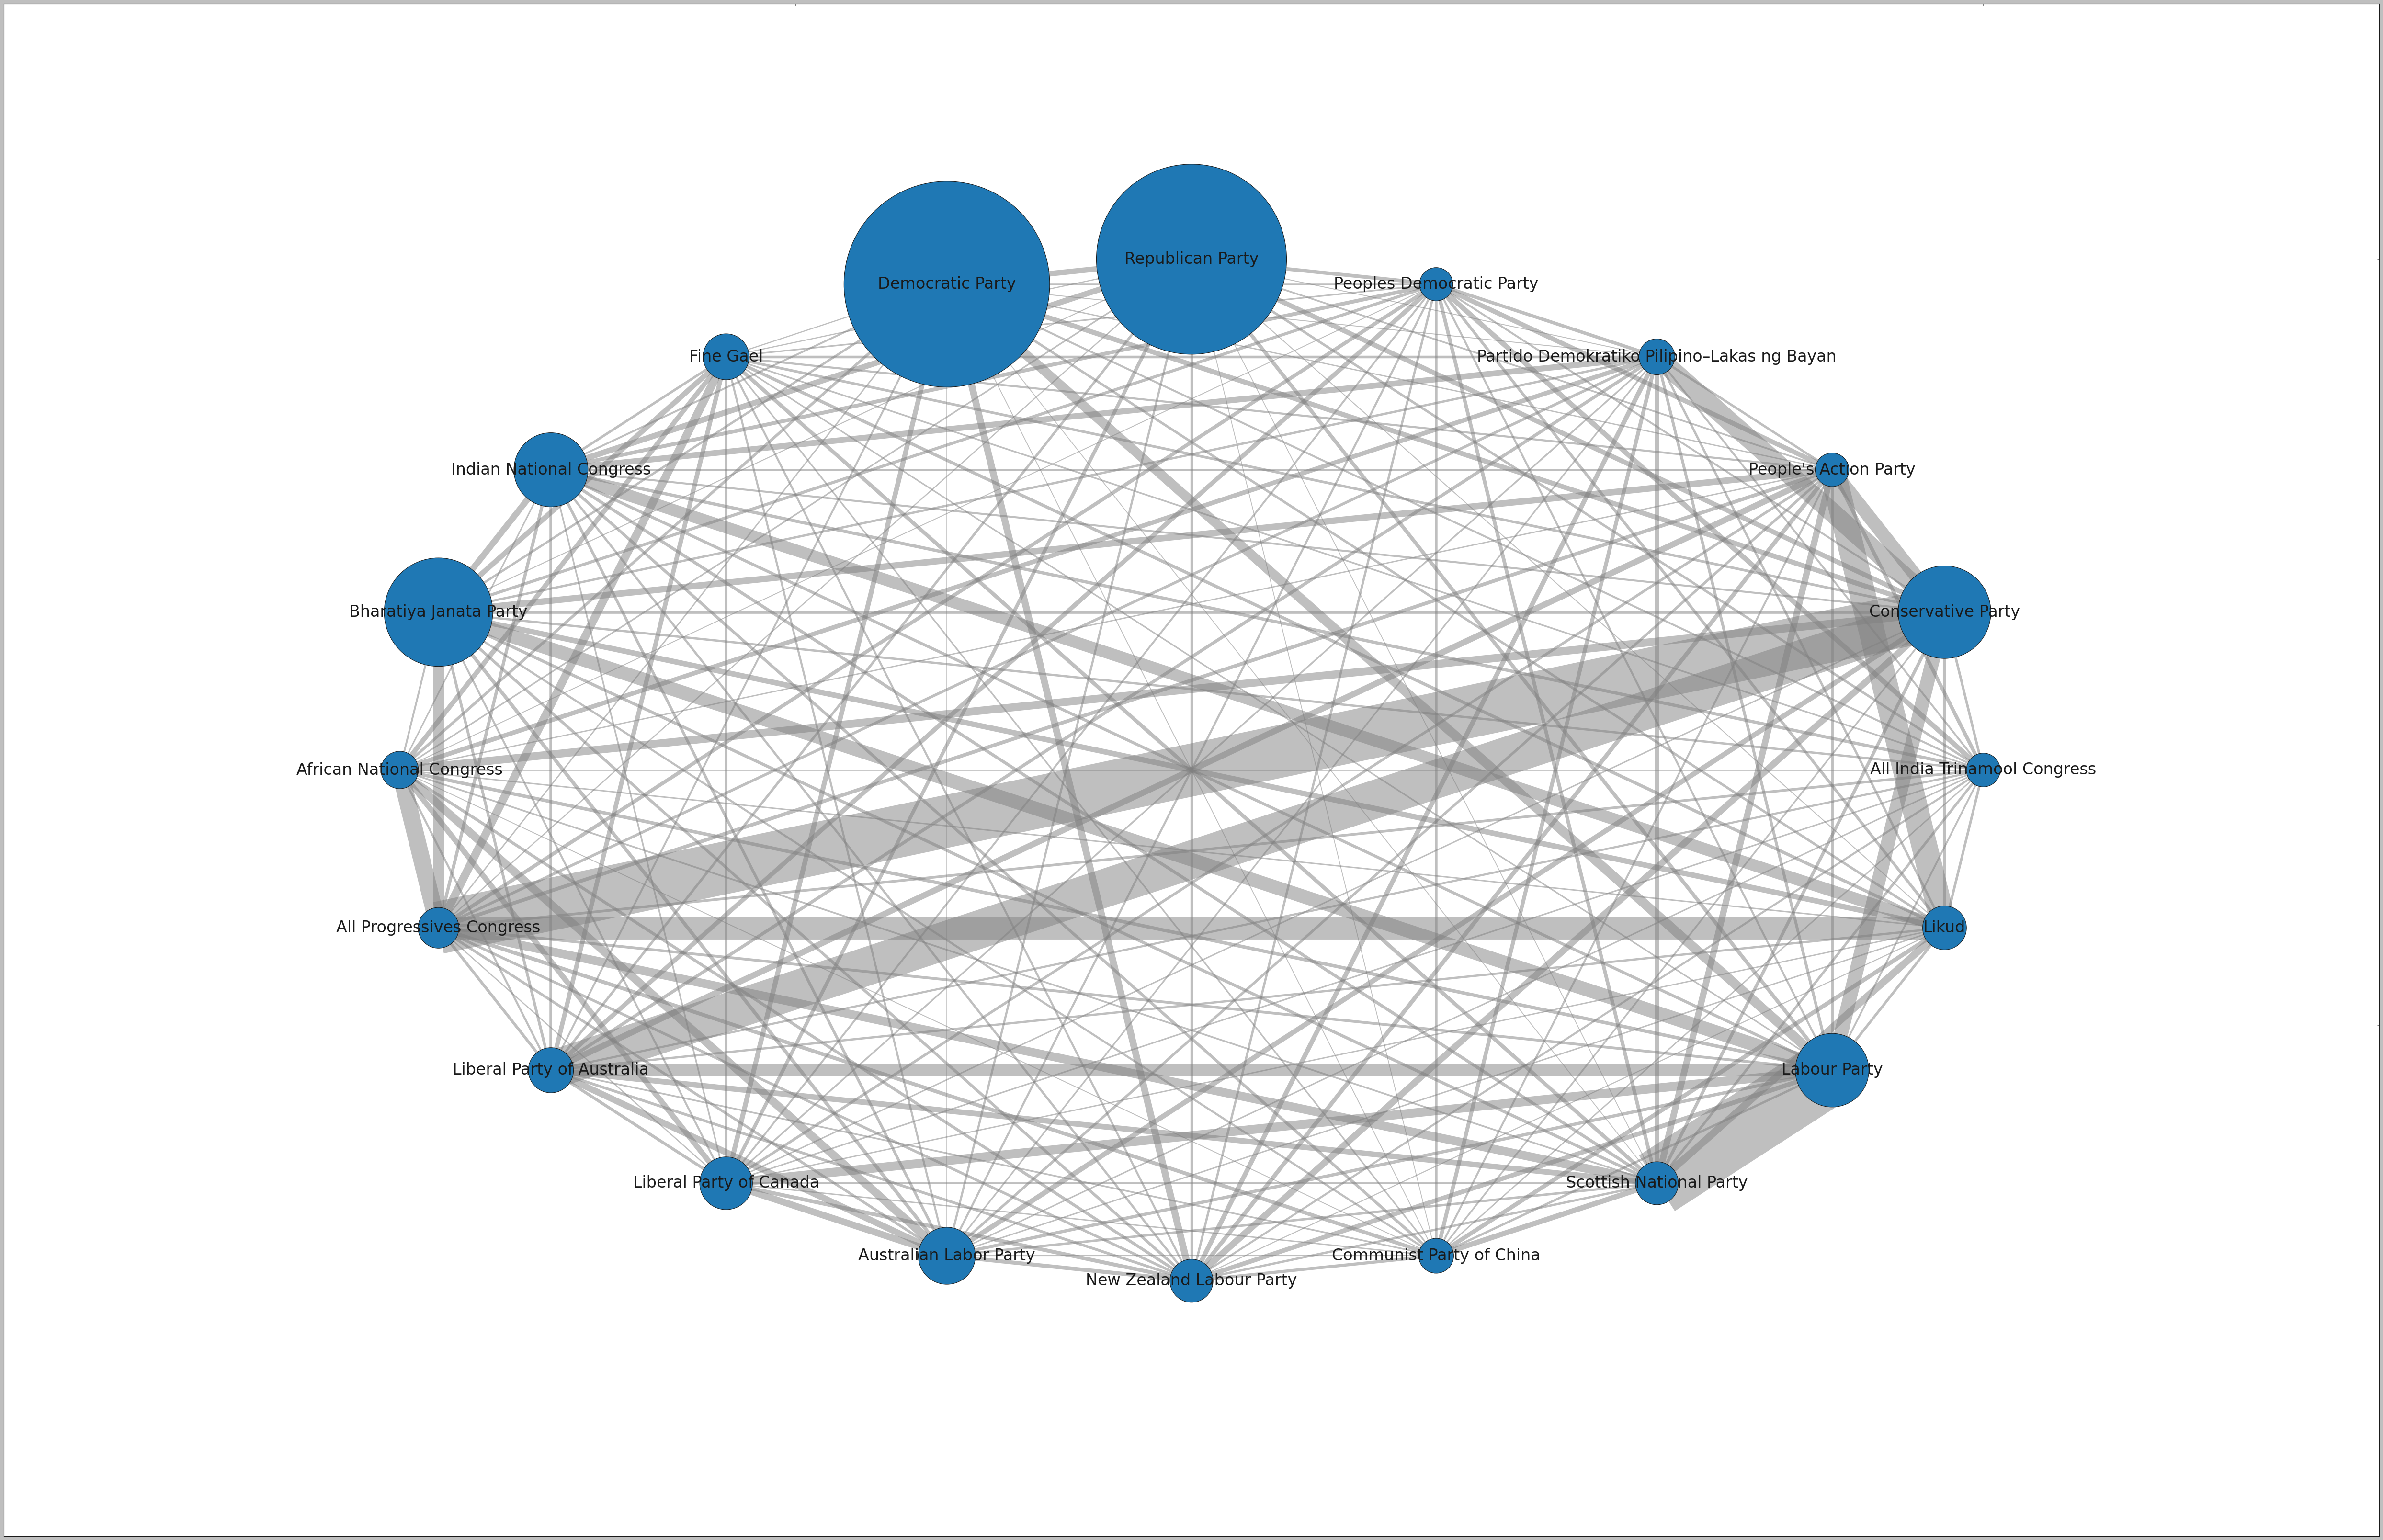

In [221]:
def weight_edges_abs_diff_divide(G, u, v, weight='weight'):
    w = 0
    for nbr in set(G[u]) & set(G[v]):
        w += 1 / (abs(G.edges[u, nbr].get(weight, 0) -  G.edges[v, nbr].get(weight, 0)))
    return w

projected_G = nx.algorithms.bipartite.generic_weighted_projected_graph(G, nx.bipartite.sets(G)[0], weight_function=weight_edges_abs_diff_divide)
weights = []
for node1, node2, data in projected_G.edges(data=True):
    # data['weight'] /= 5
    # data['weight'] /= 200
    data['weight'] /= 70

    weights.append(data['weight'])

plt.style.use('classic')
fig, ax = plt.subplots(figsize=(80,50))
pos = nx.circular_layout(projected_G)
nx.draw_networkx_nodes(projected_G, pos, ax=ax, node_size=list(map(lambda x: quotes_per_party.loc[x].values[0], projected_G.nodes())))
nx.draw_networkx_edges(projected_G, pos, ax=ax, width=weights, edge_color='grey', alpha=0.5)
_ = nx.draw_networkx_labels(projected_G, pos, {i:i for i in dict(projected_G.nodes).keys()}, ax=ax, font_size=30)